/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - loss: 0.1154 - val_loss: 0.0236
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - loss: 0.0251 - val_loss: 0.0172
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 208ms/step - loss: 0.0188 - val_loss: 0.0119
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 0.0148 - val_loss: 0.0100
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - loss: 0.0137 - val_loss: 0.0089
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - loss: 0.0119 - val_loss: 0.0093
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - loss: 0.0112 - val_loss: 0.0082
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - loss: 0.0110 - val_loss: 0.0083
Epoch 9/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 10/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - loss: 0.0105 - val_loss: 0.0073
Epoch 11/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 12/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 23

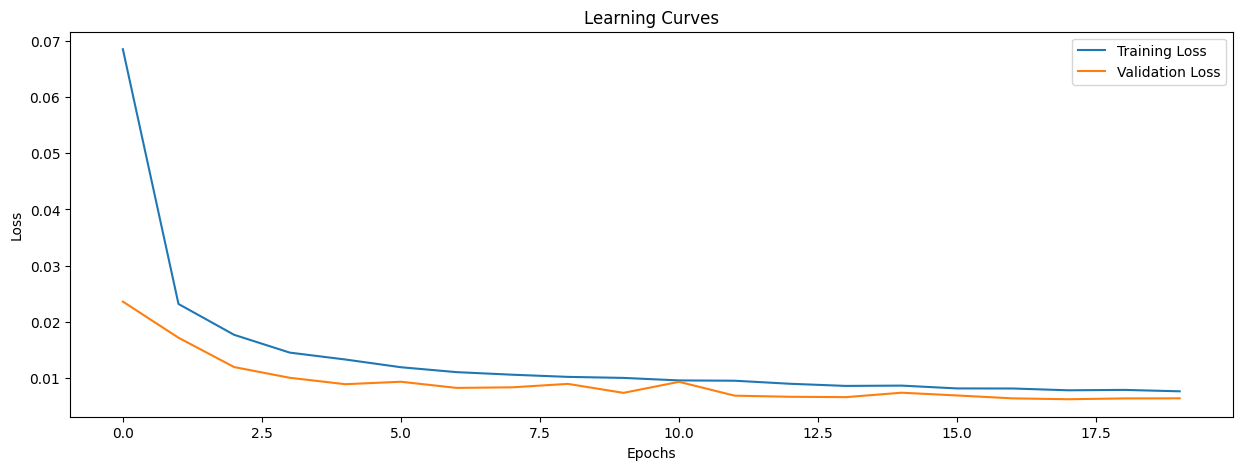

Data for 2023-04-07: 24 rows
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


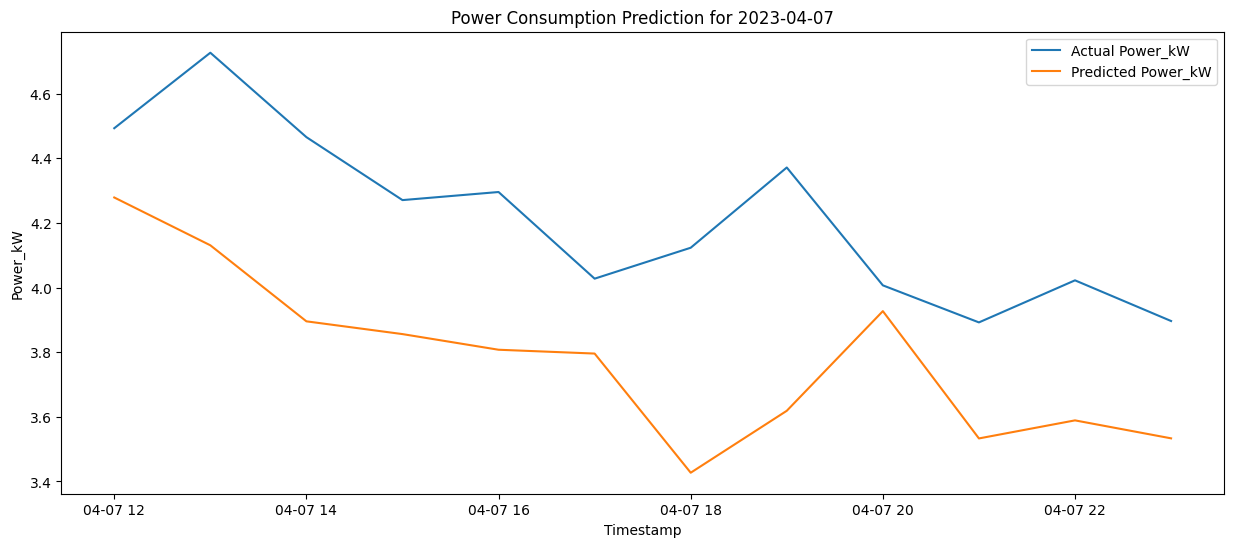

Data for 2023-W02: 168 rows
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


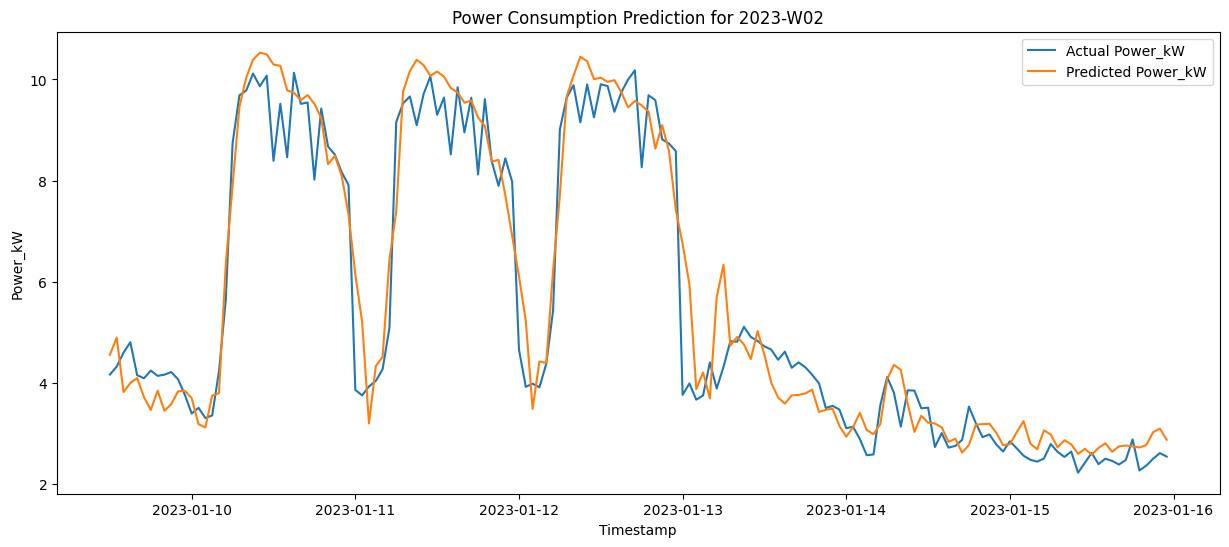

Data for 2023-01: 724 rows
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


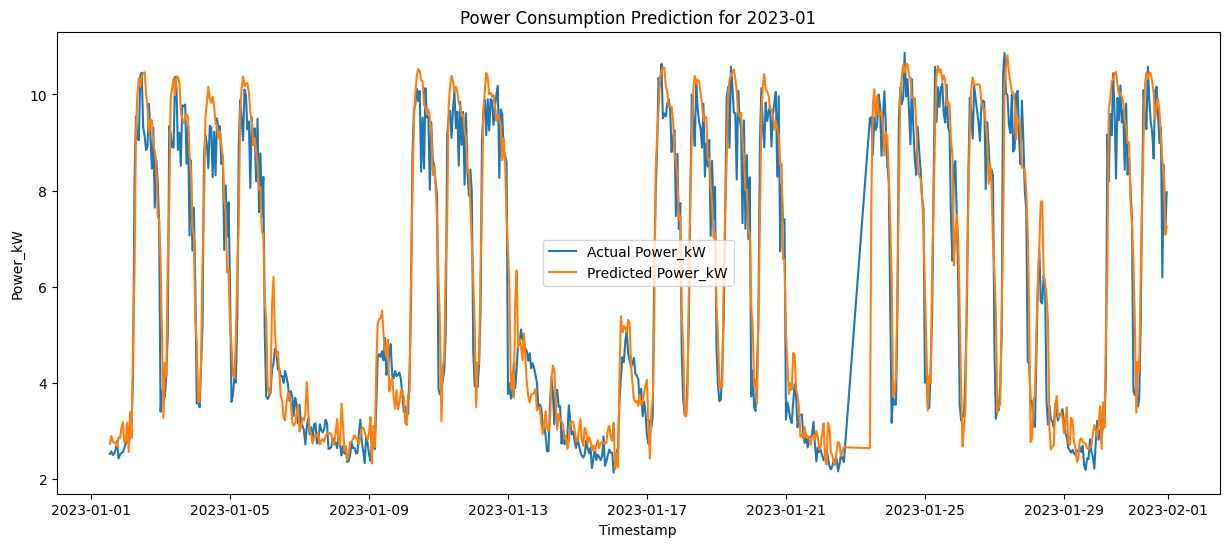

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
#------------------------------------------------------------------------------------------------------------------------
# Load and preprocess the data
file_path = 'Combined_Energy_and_Temperature_Data.csv'
data = pd.read_csv(file_path)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)
#------------------------------------------------------------------------------------------------------------------------

# Feature Engineering
data['Hour'] = data.index.hour
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
#------------------------------------------------------------------------------------------------------------------------

# Select relevant features
features = data[['Air_Pressure_kW', 'Power_kW', 'Hour', 'DayOfWeek', 'Month']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 1]  # Predicting 'Power_kW'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
#------------------------------------------------------------------------------------------------------------------------

# Adjusted sequence length
SEQ_LENGTH = 12  # Reduced sequence length to speed up training
X, y = create_sequences(scaled_features, SEQ_LENGTH)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN-LSTM model with dropout for regularization
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, X.shape[2])))  # Reduced number of filters
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Reshape(((SEQ_LENGTH - 2) * 32 // 2, 1)))  # Adjustting flatten
model.add(LSTM(25, return_sequences=True))  # LSTM units
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
#------------------------------------------------------------------------------------------------------------------------

# Train the model with fewer epochs and larger batch size for faster training
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)  # Reduced epochs and increased batch size

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred), axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

# Plot the learning curves
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
#------------------------------------------------------------------------------------------------------------------------

# Function to plot predictions for a specific day
def plot_daily_predictions(data, year, month, day, model, scaler, seq_length=12):
    daily_data = data[(data.index.year == year) & (data.index.month == month) & (data.index.day == day)]
    print(f"Data for {year}-{month:02d}-{day:02d}: {daily_data.shape[0]} rows")

    if daily_data.empty:
        print(f"No data available for {year}-{month:02d}-{day:02d}")
        return

    if len(daily_data) < seq_length:
        print(f"Not enough data for sequence creation on {year}-{month:02d}-{day:02d}")
        return

    # Normalize the daily data
    scaled_daily_features = scaler.transform(daily_data[['Air_Pressure_kW', 'Power_kW', 'Hour', 'DayOfWeek', 'Month']])
    X_day, y_day = create_sequences(scaled_daily_features, seq_length)

    if len(X_day) == 0 or len(y_day) == 0:
        print(f"Not enough sequence data for {year}-{month:02d}-{day:02d}")
        return

    y_day_pred = model.predict(X_day)
    y_day_pred_inv = scaler.inverse_transform(np.concatenate((X_day[:, -1, :-1], y_day_pred), axis=1))[:, -1]
    y_day_inv = scaler.inverse_transform(np.concatenate((X_day[:, -1, :-1], y_day.reshape(-1, 1)), axis=1))[:, -1]

    plt.figure(figsize=(15, 6))
    plt.plot(daily_data.index[seq_length:], y_day_inv, label='Actual Power_kW')
    plt.plot(daily_data.index[seq_length:], y_day_pred_inv, label='Predicted Power_kW')
    plt.xlabel('Timestamp')
    plt.ylabel('Power_kW')
    plt.title(f'Power Consumption Prediction for {year}-{month:02d}-{day:02d}')
    plt.legend()
    plt.show()
#------------------------------------------------------------------------------------------------------------------------

# Function to plot predictions for a specific week
def plot_weekly_predictions(data, year, week, model, scaler, seq_length=12):
    weekly_data = data[(data.index.year == year) & (data.index.isocalendar().week == week)]
    print(f"Data for {year}-W{week:02d}: {weekly_data.shape[0]} rows")

    if weekly_data.empty:
        print(f"No data available for {year}-W{week:02d}")
        return

    if len(weekly_data) < seq_length:
        print(f"Not enough data for sequence creation on {year}-W{week:02d}")
        return

    # Normalize the weekly data
    scaled_weekly_features = scaler.transform(weekly_data[['Air_Pressure_kW', 'Power_kW', 'Hour', 'DayOfWeek', 'Month']])
    X_week, y_week = create_sequences(scaled_weekly_features, seq_length)

    if len(X_week) == 0 or len(y_week) == 0:
        print(f"Not enough sequence data for {year}-W{week:02d}")
        return

    y_week_pred = model.predict(X_week)
    y_week_pred_inv = scaler.inverse_transform(np.concatenate((X_week[:, -1, :-1], y_week_pred), axis=1))[:, -1]
    y_week_inv = scaler.inverse_transform(np.concatenate((X_week[:, -1, :-1], y_week.reshape(-1, 1)), axis=1))[:, -1]

    plt.figure(figsize=(15, 6))
    plt.plot(weekly_data.index[seq_length:], y_week_inv, label='Actual Power_kW')
    plt.plot(weekly_data.index[seq_length:], y_week_pred_inv, label='Predicted Power_kW')
    plt.xlabel('Timestamp')
    plt.ylabel('Power_kW')
    plt.title(f'Power Consumption Prediction for {year}-W{week:02d}')
    plt.legend()
    plt.show()
#------------------------------------------------------------------------------------------------------------------------

# Function to plot predictions for a specific month
def plot_monthly_predictions(data, year, month, model, scaler, seq_length=12):
    monthly_data = data[(data.index.year == year) & (data.index.month == month)]
    print(f"Data for {year}-{month:02d}: {monthly_data.shape[0]} rows")

    if monthly_data.empty:
        print(f"No data available for {year}-{month:02d}")
        return

    if len(monthly_data) < seq_length:
        print(f"Not enough data for sequence creation on {year}-{month:02d}")
        return

    # Normalize the monthly data
    scaled_monthly_features = scaler.transform(monthly_data[['Air_Pressure_kW', 'Power_kW', 'Hour', 'DayOfWeek', 'Month']])
    X_month, y_month = create_sequences(scaled_monthly_features, seq_length)

    if len(X_month) == 0 or len(y_month) == 0:
        print(f"Not enough sequence data for {year}-{month:02d}")
        return

    y_month_pred = model.predict(X_month)
    y_month_pred_inv = scaler.inverse_transform(np.concatenate((X_month[:, -1, :-1], y_month_pred), axis=1))[:, -1]
    y_month_inv = scaler.inverse_transform(np.concatenate((X_month[:, -1, :-1], y_month.reshape(-1, 1)), axis=1))[:, -1]

    plt.figure(figsize=(15, 6))
    plt.plot(monthly_data.index[seq_length:], y_month_inv, label='Actual Power_kW')
    plt.plot(monthly_data.index[seq_length:], y_month_pred_inv, label='Predicted Power_kW')
    plt.xlabel('Timestamp')
    plt.ylabel('Power_kW')
    plt.title(f'Power Consumption Prediction for {year}-{month:02d}')
    plt.legend()
    plt.show()
#------------------------------------------------------------------------------------------------------------------------

# Example usage:
# Plot daily predictions for a specific date
plot_daily_predictions(data, 2023, 4, 7, model, scaler, seq_length=12)

# Plot weekly predictions for a specific week
plot_weekly_predictions(data, 2023, 2, model, scaler, seq_length=12)

# Plot monthly predictions for a specific month
plot_monthly_predictions(data, 2023, 1, model, scaler, seq_length=12)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - loss: 0.1374 - val_loss: 0.0264
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - loss: 0.0280 - val_loss: 0.0169
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - loss: 0.0182 - val_loss: 0.0107
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - loss: 0.0132 - val_loss: 0.0080
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - loss: 0.0115 - val_loss: 0.0080
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - loss: 0.0108 - val_loss: 0.0074
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 198ms/step - loss: 0.0099 - val_loss: 0.0075
Epoch 9/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - loss: 0.0094 - val_loss: 0.0070
Epoch 10/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 11/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 12/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 211ms/ste

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
RMSE: 0.8848233155520887
MAE: 0.6589442197599794
MAPE: 11.790097028446912%


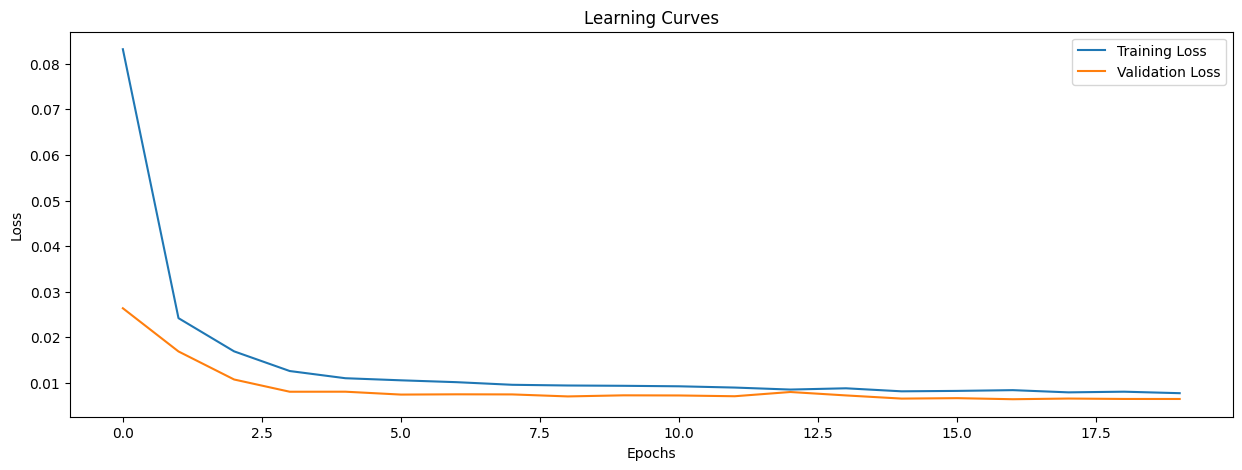

Data for 2023-04-09: 24 rows
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


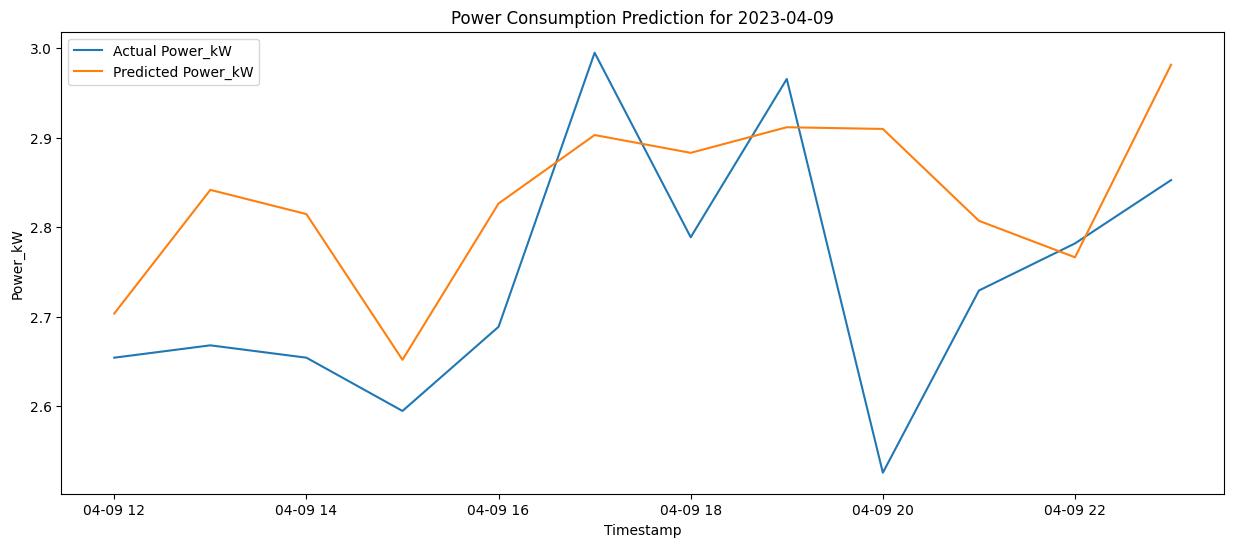

Data for 2023-W02: 168 rows
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


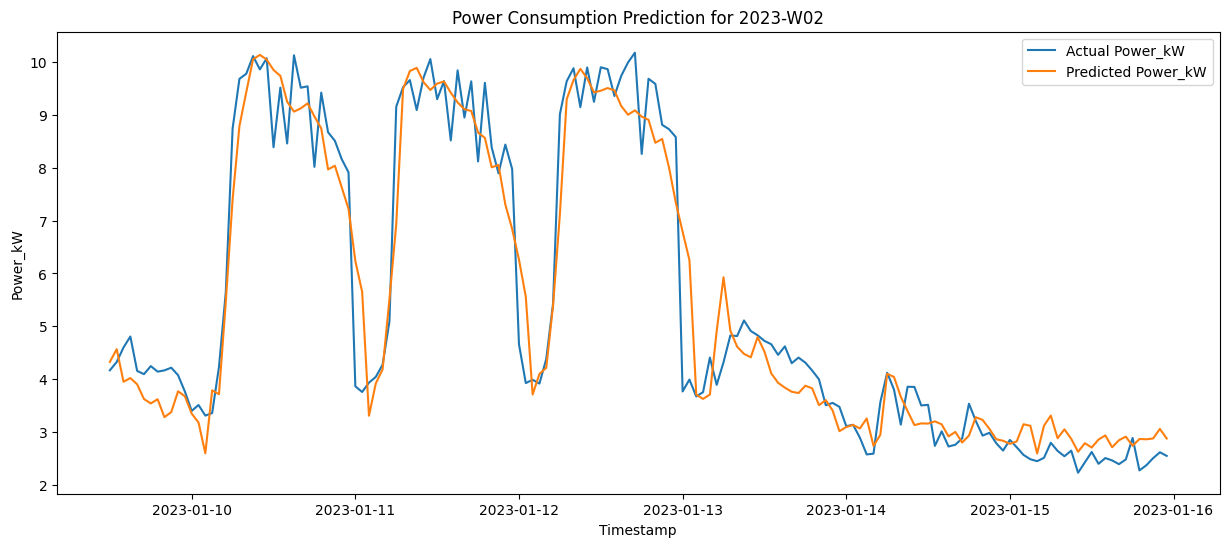

Data for 2023-02: 672 rows
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


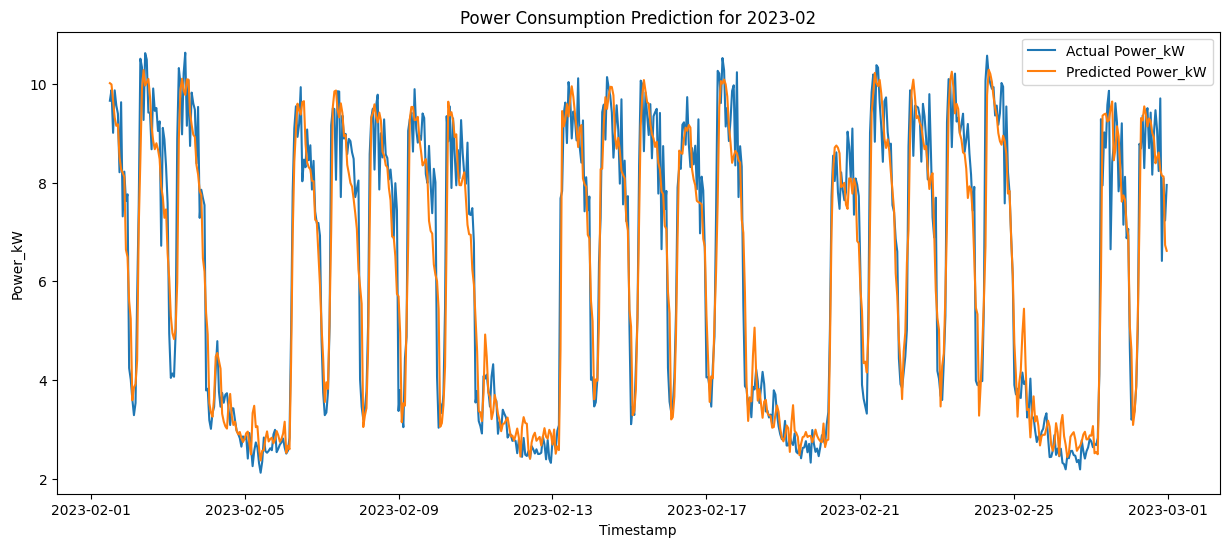

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib
#------------------------------------------------------------------------------------------------------------------------

# Load and preprocess the data
file_path = 'Combined_Energy_and_Temperature_Data.csv'
data = pd.read_csv(file_path)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)
#------------------------------------------------------------------------------------------------------------------------

# Feature Engineering
data['Hour'] = data.index.hour
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
#------------------------------------------------------------------------------------------------------------------------

# Select relevant features
features = data[['Air_Pressure_kW', 'Power_kW', 'Hour', 'DayOfWeek', 'Month']]
#------------------------------------------------------------------------------------------------------------------------

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
#------------------------------------------------------------------------------------------------------------------------

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 1]  # Predicting 'Power_kW'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Adjusted sequence length
SEQ_LENGTH = 12  # Reduced sequence length to speed up training
X, y = create_sequences(scaled_features, SEQ_LENGTH)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN-LSTM model with dropout for regularization
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Reshape(((SEQ_LENGTH - 2) * 32 // 2, 1)))
model.add(LSTM(25, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs and larger batch size for faster training
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

# Save the model
model.save('energy_consumption_model.h5')

# Save the scaler
joblib.dump(scaler, 'scaler.save')

# Load the model
model = load_model('energy_consumption_model.h5')

# Load the scaler
scaler = joblib.load('scaler.save')
#------------------------------------------------------------------------------------------------------------------------

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred), axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

# Plot the learning curves
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()
#------------------------------------------------------------------------------------------------------------------------

# Function to plot predictions for a specific day
def plot_daily_predictions(data, year, month, day, model, scaler, seq_length=12):
    daily_data = data[(data.index.year == year) & (data.index.month == month) & (data.index.day == day)]
    print(f"Data for {year}-{month:02d}-{day:02d}: {daily_data.shape[0]} rows")

    if daily_data.empty:
        print(f"No data available for {year}-{month:02d}-{day:02d}")
        return

    if len(daily_data) < seq_length:
        print(f"Not enough data for sequence creation on {year}-{month:02d}-{day:02d}")
        return

    # Normalize the daily data
    scaled_daily_features = scaler.transform(daily_data[['Air_Pressure_kW', 'Power_kW', 'Hour', 'DayOfWeek', 'Month']])
    X_day, y_day = create_sequences(scaled_daily_features, seq_length)

    if len(X_day) == 0 or len(y_day) == 0:
        print(f"Not enough sequence data for {year}-{month:02d}-{day:02d}")
        return

    y_day_pred = model.predict(X_day)
    y_day_pred_inv = scaler.inverse_transform(np.concatenate((X_day[:, -1, :-1], y_day_pred), axis=1))[:, -1]
    y_day_inv = scaler.inverse_transform(np.concatenate((X_day[:, -1, :-1], y_day.reshape(-1, 1)), axis=1))[:, -1]

    plt.figure(figsize=(15, 6))
    plt.plot(daily_data.index[seq_length:], y_day_inv, label='Actual Power_kW')
    plt.plot(daily_data.index[seq_length:], y_day_pred_inv, label='Predicted Power_kW')
    plt.xlabel('Timestamp')
    plt.ylabel('Power_kW')
    plt.title(f'Power Consumption Prediction for {year}-{month:02d}-{day:02d}')
    plt.legend()
    plt.show()
#------------------------------------------------------------------------------------------------------------------------

# Function to plot predictions for a specific week
def plot_weekly_predictions(data, year, week, model, scaler, seq_length=12):
    weekly_data = data[(data.index.year == year) & (data.index.isocalendar().week == week)]
    print(f"Data for {year}-W{week:02d}: {weekly_data.shape[0]} rows")

    if weekly_data.empty:
        print(f"No data available for {year}-W{week:02d}")
        return

    if len(weekly_data) < seq_length:
        print(f"Not enough data for sequence creation on {year}-W{week:02d}")
        return

    # Normalize the weekly data
    scaled_weekly_features = scaler.transform(weekly_data[['Air_Pressure_kW', 'Power_kW', 'Hour', 'DayOfWeek', 'Month']])
    X_week, y_week = create_sequences(scaled_weekly_features, seq_length)

    if len(X_week) == 0 or len(y_week) == 0:
        print(f"Not enough sequence data for {year}-W{week:02d}")
        return

    y_week_pred = model.predict(X_week)
    y_week_pred_inv = scaler.inverse_transform(np.concatenate((X_week[:, -1, :-1], y_week_pred), axis=1))[:, -1]
    y_week_inv = scaler.inverse_transform(np.concatenate((X_week[:, -1, :-1], y_week.reshape(-1, 1)), axis=1))[:, -1]

    plt.figure(figsize=(15, 6))
    plt.plot(weekly_data.index[seq_length:], y_week_inv, label='Actual Power_kW')
    plt.plot(weekly_data.index[seq_length:], y_week_pred_inv, label='Predicted Power_kW')
    plt.xlabel('Timestamp')
    plt.ylabel('Power_kW')
    plt.title(f'Power Consumption Prediction for {year}-W{week:02d}')
    plt.legend()
    plt.show()
#------------------------------------------------------------------------------------------------------------------------

# Function to plot predictions for a specific month
def plot_monthly_predictions(data, year, month, model, scaler, seq_length=12):
    monthly_data = data[(data.index.year == year) & (data.index.month == month)]
    print(f"Data for {year}-{month:02d}: {monthly_data.shape[0]} rows")

    if monthly_data.empty:
        print(f"No data available for {year}-{month:02d}")
        return

    if len(monthly_data) < seq_length:
        print(f"Not enough data for sequence creation on {year}-{month:02d}")
        return

    # Normalize the monthly data
    scaled_monthly_features = scaler.transform(monthly_data[['Air_Pressure_kW', 'Power_kW', 'Hour', 'DayOfWeek', 'Month']])
    X_month, y_month = create_sequences(scaled_monthly_features, seq_length)

    if len(X_month) == 0 or len(y_month) == 0:
        print(f"Not enough sequence data for {year}-{month:02d}")
        return

    y_month_pred = model.predict(X_month)
    y_month_pred_inv = scaler.inverse_transform(np.concatenate((X_month[:, -1, :-1], y_month_pred), axis=1))[:, -1]
    y_month_inv = scaler.inverse_transform(np.concatenate((X_month[:, -1, :-1], y_month.reshape(-1, 1)), axis=1))[:, -1]

    plt.figure(figsize=(15, 6))
    plt.plot(monthly_data.index[seq_length:], y_month_inv, label='Actual Power_kW')
    plt.plot(monthly_data.index[seq_length:], y_month_pred_inv, label='Predicted Power_kW')
    plt.xlabel('Timestamp')
    plt.ylabel('Power_kW')
    plt.title(f'Power Consumption Prediction for {year}-{month:02d}')
    plt.legend()
    plt.show()

#------------------------------------------------------------------------------------------------------------------------

# Plot daily predictions for a specific date
plot_daily_predictions(data, 2023, 4, 9, model, scaler, seq_length=12)

# Plot weekly predictions for a specific week
plot_weekly_predictions(data, 2023, 2, model, scaler, seq_length=12)

# Plot monthly predictions for a specific month
plot_monthly_predictions(data, 2023, 2, model, scaler, seq_length=12)


In [ ]:
from tensorflow.keras.models import load_model
import joblib
import pandas as pd

# Load the model
model = load_model('energy_consumption_model.h5')

# Load the scaler
scaler = joblib.load('scaler.save')

# Load and preprocess the data
file_path = 'Combined_Energy_and_Temperature_Data.csv'
data = pd.read_csv(file_path)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)

# Feature Engineering
data['Hour'] = data.index.hour
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month


Data for 2023-01-02: 24 rows
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


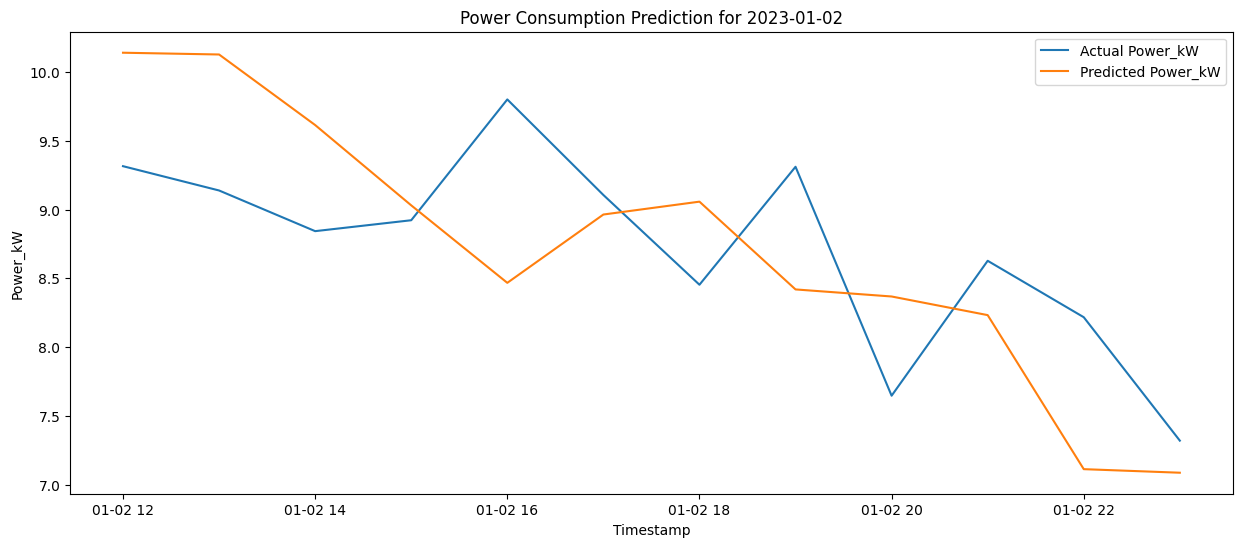

Data for 2023-W08: 168 rows
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


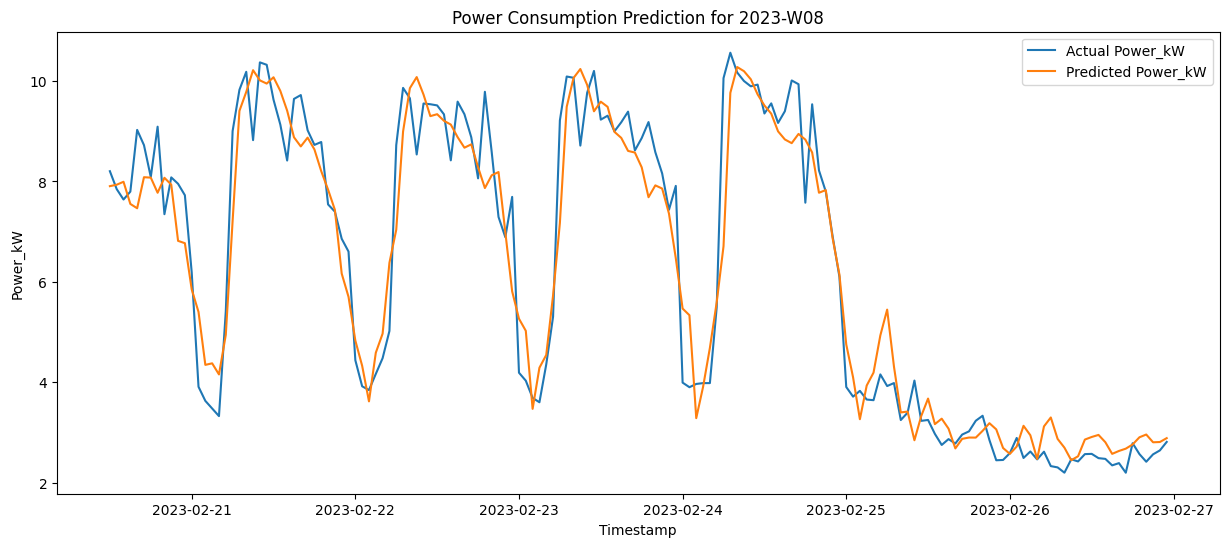

Data for 2023-10: 737 rows
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


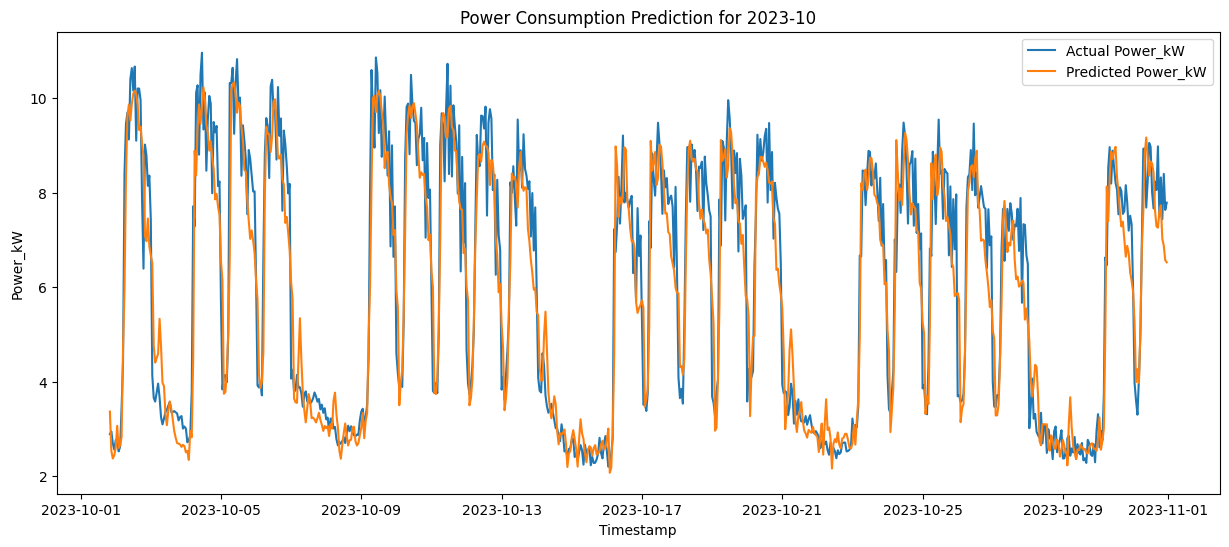

In [3]:
# Plot daily predictions for a specific date
plot_daily_predictions(data, 2023, 1, 2, model, scaler, seq_length=12)

# Plot weekly predictions for a specific week
plot_weekly_predictions(data, 2023, 8, model, scaler, seq_length=12)

# Plot monthly predictions for a specific month
plot_monthly_predictions(data, 2023, 10, model, scaler, seq_length=12)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
